Note: you need to upload the training data and/or syzygy files to the notebook before running this code

In [ ]:
!pip install chess
#import chess
#print(chess.__version__)

     |████████████████████████████████| 146 kB 4.2 MB/s 


In [ ]:
# Import relevant modules
from matplotlib import pyplot as plt
import numpy as np
import chess
import chess.syzygy
import random
import tensorflow as tf
import pandas as pd
#import import_data as imp
#import train_model as train
#import define_model as defmod
#import graph as gr
#import gen_pos as gp
print(chess.__version__)

1.6.1


Graph.py

In [ ]:
# this file is where graphing functions will go

# We can use this to plot the training loss over time
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    plt.show()

gen_pos.py

In [ ]:
def gen_fen(material):
    """Return a board with the specific material balance"""""
    # Step 1: Create a blank board with either white or black to move
    # We are assuming no castling or ep capture will be possible
    if random.randint(0, 1) == 1:
        board = chess.Board('8/8/8/8/8/8/8/8 w - - 0 1')
    else:
        board = chess.Board('8/8/8/8/8/8/8/8 b - - 0 1')

    # Step 2: Decide whether the first group of material is for white or black
    if random.randint(0, 1) == 1:
        material = material.swapcase()

    # Step 3: Loop over material and add it to the board
    dest_squares = random.sample(range(64), len(material))
    for piece in material:
        location = dest_squares.pop()
        board.set_piece_at(location, chess.Piece.from_symbol(piece))
    # Step 4: Check that the position is valid
    if not board.is_valid() or board.is_checkmate() or board.is_stalemate():
        # Recursively get a new try
        board = gen_fen(material)
    return board


def is_white_square(square):
    """Returns True if the square is on the 'white' diagonals"""
    file = chess.square_file(square)
    rank = chess.square_rank(square)
    if (file + rank) % 2 == 0:
        return 1
    else:
        return 0


def board_to_plane(board):
    """Takes a board position and translates it into a plane of binary values"""
    """Old code that returned a vector"""
    # 0-63,448-511: bishop on dark squares    PNBRQK == 123456
    # 64- 512-:  black pawns, white pawns     white = True, black = False
    # 128- 576-: knight
    # 192- 640-: bishop on light squares
    # 256- 704-: rook
    # 320- 768-: queen
    # 384- 832-895: king
    # The location of a square is described by:
    # 448*(color white=1 black=0) + 64*(piecetype 1-6) + square
    #     - 64*3*is_a_bishop*is_on_light_square
    # 896-961 : side to move color (white = 1s)
    plane = np.zeros(896, dtype=int)
    for square in range(64):
        piece_type = board.piece_type_at(square)
        if piece_type is None:
            pass
        else:
            if board.color_at(square) == chess.WHITE:
                piece_color = 1
            else:
                piece_color = 0
            index = 448 * piece_color + 64 * (piece_type - 1) + square
            if piece_type == chess.BISHOP:
                # Bishops on white diagonals go in the 0 index instead of 3.
                index = index - 64 * 3 * is_white_square(square)
            plane[index] = 1
    if board.turn == chess.WHITE:
        col = np.ones(64)
    else:
        col = np.zeros(64)
    # print(plane)
    plane2 = np.concatenate((plane, col))
    return plane2


def board_to_planev1(board):
    """Takes a board position and translates it into a planes of binary values"""
    """New code retains the 8x8 planes"""
    # The resulting plane will be (8,8,15) - apparently tensorflow prefers channels last
    # 0, 7: bishop on dark squares    PNBRQK == 123456
    # 1- 8-:  black pawns, white pawns     white = True, black = False
    # 2- 9-: knight
    # 3- 10-: bishop on light squares
    # 4- 11-: rook
    # 5- 12-: queen
    # 6- 13 : king
    # 14    : color white = 1
    # The location of a square is described by:
    # 448*(color white=1 black=0) + 64*(piecetype 1-6) + square
    #     - 64*3*is_a_bishop*is_on_light_square
    # 896-961 : side to move color (white = 1s)
    plane = np.zeros((8, 8, 15), dtype=int)
    for square in range(64):
        piece_type = board.piece_type_at(square)
        if piece_type is None:
            pass
        else:
            if board.color_at(square) == chess.WHITE:
                piece_color = 1
            else:
                piece_color = 0
            file = chess.square_file(square)
            rank = chess.square_rank(square)
            index = 7 * piece_color + piece_type -1
            if piece_type == chess.BISHOP:
                # Bishops on white diagonals go in the 0/7 index instead of 3/10.
                index = index - 3 * is_white_square(square)

            plane[rank, file, index] = 1
    if board.turn == chess.WHITE:
        col = 1
    else:
        col = 0
    plane[:, :, 14] = col
    return plane


def board_label(board):
    """Returns the training labels for the board from Syzygy lookup"""
    # 0 draw for side-to-move, 1 win for side-to-move (more than 50 moves), 2 win for side-to-move
    # -1 loss in more than 50, -2 loss in <50
    with chess.syzygy.open_tablebase("./") as tablebase:
        # board = chess.Board("8/2K5/4B3/3N4/8/8/4k3/8 b - - 0 1")
        wdl = tablebase.probe_wdl(board)

    # 0 draw, x win in x, -x loss in x
    # counts may be off by 1
    with chess.syzygy.open_tablebase("./") as tablebase:
        # board = chess.Board("8/2K5/4B3/3N4/8/8/4k3/8 b - - 0 1")
        dtz = tablebase.probe_dtz(board)
    if wdl == 0:
        win = 0
        draw = 1
        loss = 0
    elif wdl > 0:
        win = 1
        draw = 0
        loss = 0
    else:
        win = 0
        draw = 0
        loss = 1
    if dtz > 0:
        quality = 2000 - dtz
    elif dtz < 0:
        quality = -2000 - dtz
    else:
        quality = 0

    return win, draw, loss, quality


def adjust_case(input_str):
    """This converts endgame descriptors so that the first block is capitalized"""
    """and the second block is lowercase.  e.g.  krpkq to KRPkq"""
    lower = input_str.lower()
    second_k = lower.find("k", 1)
    # print(f"second k at {second_k}")
    out1 = lower[:second_k].upper()
    out2 = lower[second_k:]
    output_str = out1+out2
    if second_k == -1:
        output_str = "fail"
    return output_str


def ask_for_input():
    need_input = True
    while need_input:
        balance = input("Please enter the endgame (e.g. KRkp): ")
        balance = adjust_case(balance)
        # print(f"After Adjusting: {balance}")
        number = int(input("Please enter the number of training examples: "))
        if number > 0:
            need_input = False
        if balance == "fail":
            need_input = True
        if need_input:
            print("There was a problem with the inputs.")

    return balance, number


def generate_training():
    material_balance, target_count = ask_for_input()
    plane_version = 'v1'
    # Note: it took about 1:30 to generate 10,000 positions
    X_train = []
    y_train = []
    for i in range(target_count):
        my_board = gen_fen(material_balance)
        my_plane = board_to_planev1(my_board)
        my_label = board_label(my_board)
        X_train.append(my_plane)
        y_train.append(my_label)
        print(i)

    # Converts from a list to an array at the end; faster than concat array
    X_train = np.stack(X_train, axis=0)
    y_train = np.stack(y_train, axis=0)
    print(X_train.shape)
    print(y_train.shape)
    print("frequency list:")
    unique_elements, counts_elements = np.unique(y_train[:, 3], return_counts=True)
    print("Frequency of unique values of the said array:")
    print(np.asarray((unique_elements, counts_elements)))

    outfile = "train_"+material_balance.lower()+str(int(target_count/1000))+"K"+plane_version+".npz"
    # Save as a compressed npz file
    np.savez_compressed(outfile, X_train=X_train, y_train=y_train)
    print(f"Data saved to {outfile}")

    # test that we can read the data
    # print("Doing a test read of the data")
    # npzfile2 = np.load(outfile)
    #    print("npz variables")
    #    print(npzfile.files)
    #    print(npzfile['y_train'])
    # X_t2 = npzfile2['X_train']
    # y_t2 = npzfile2['y_train']
    # print(X_t2.shape)
    # print(y_t2.shape)
    #print(y_t2)

import_data.py

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np


def import_endgame(filename):
    npzfile2 = np.load(filename)
    #    print("npz variables")
    #    print(npzfile.files)
    #    print(npzfile['y_train'])
    X_train = npzfile2['X_train']
    y_train = npzfile2['y_train']

    # Converting time to mate back to an number (0,x)
    y_train[y_train[:, 3] < 0, 3] = (-2000 - y_train[y_train[:, 3] < 0, 3]) / 2
    y_train[y_train[:, 3] > 0, 3] = (2001 - y_train[y_train[:, 3] > 0, 3]) / 2
    y_train[:, 3] += 16

    # Or, convert the int values into floats, this doesn't seem to matter
    # X_train = X_train.astype(float)
    # y_train = y_train.astype(float)

    print("frequency list:")
    unique_elements, counts_elements = np.unique(y_train[:, 3], return_counts=True)
    print("Frequency of unique values of the said array:")
    print(np.asarray((unique_elements, counts_elements)))
    return X_train, y_train

define_model.py

In [ ]:
def create_model_eg1(my_learning_rate):
    """Create and compile a deep neural net."""
    # This is a first try to get a simple model that works
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(8, 8, 15)))
    model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=['MeanSquaredError'])

    return model

def create_model_eg5(my_learning_rate):
    """Create and compile a deep neural net."""
    # This is a first try to get a simple model that works
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(8, 8, 15)))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=['MeanSquaredError'])

    return model


def create_model_eg_bin3orig(my_learning_rate):
    """Create and compile a deep neural net."""
    # This is a first try to get a simple model that works
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3,3), input_shape=(8,8,15), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3,3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=33))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

def create_model_eg_bin3(my_learning_rate):
    """Create and compile a deep neural net."""
    # This is a first try to get a simple model that works
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3,3), input_shape=(8,8,15), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3,3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=64, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=0.1)))
    model.add(tf.keras.layers.Dense(units=33))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

def create_model_eg_bin3b(my_learning_rate):
    """Create and compile a deep neural net."""
    # L2 reg: 0.1 in both destroyed accuracy
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3,3), input_shape=(8,8,15), strides=(1, 1), padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(l=0.005)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3,3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3,3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=64, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(l=0.005)))
    model.add(tf.keras.layers.Dense(units=33))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

train_model.py

In [ ]:
def train_model(model, tb_callback, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
    """Train the model by feeding it data."""

    history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                        epochs=epochs, shuffle=True, callbacks=[tb_callback],
                        validation_split=validation_split)

    # To track the progression of training, gather a snapshot
    # of the model's metrics at each epoch.
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist

main.py

Using Tensorflow 2.6.0
Welcome to chess_pos_gen
We are going to generate a file of chess endgame training examples
to use in training a neural net.
Do you need to generate endgame training data? n
Do you want to train a net? y
Please enter the endgame (e.g. KRkp): krk
Please enter the number of training examples: 50000
frequency list:
Frequency of unique values of the said array:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32]
 [ 386 2141 4525 4126 3648 2892 1949 1705 1451  666  570  476  205   70  233   85 2830  189  592  462  243  618 1113 1417 2147 2647 2409 2603 2671 2128 2007  680  116]]
(50000, 8, 8, 15)
(50000, 4)
[ 0  1  0 16]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 8, 8, 256)         34816     
_________________

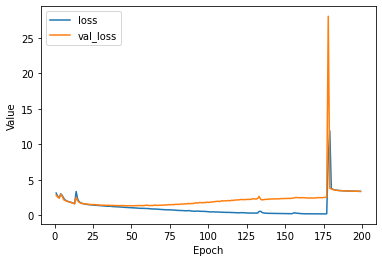

In [ ]:
def ask_gen_training():
    yes_no = input("Do you need to generate endgame training data? ")
    if len(yes_no) == 0:
        pass
    elif yes_no[0].lower() == "y":
        generate_training()


def ask_train_net():
    yes_no = input("Do you want to train a net? ")
    if len(yes_no) == 0:
        pass
    elif yes_no[0].lower() == "n":
        return

    # Get the data to use for training
    plane_version="v1"
    material_balance, target_count = ask_for_input()
    material_balance = material_balance.lower()
    input_file = "train_"+material_balance+str(int(target_count/1000))+"K"+plane_version+".npz"

    (x_train, y_train4) = import_endgame(input_file)
    # Print a sample image
    print(x_train.shape)
    print(y_train4.shape)
    print(y_train4[18])
    y_train = y_train4[:, 3]  # Column 3 is the score (-2000, 2000)

    ##############
    # The following variables are the hyperparameters.
    learning_rate = 0.003
    epochs = 200
    batch_size = 2000
    validation_split = 0.2

    # Establish the model's topography.
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/bin3/", histogram_freq=1)
    my_model = create_model_eg_bin3b(learning_rate)
    my_model.summary()
    # Train the model on the normalized training set.
    epochs, hist = train_model(my_model, tb_callback, x_train, y_train,
                                     epochs, batch_size, validation_split)

    # Plot a graph of the metric vs. epochs.
    # list_of_metrics_to_plot = ['accuracy','val_accuracy']
    list_of_metrics_to_plot = ['loss', 'val_loss']
    plot_curve(epochs, hist, list_of_metrics_to_plot)


def set_options():
    print(f"Using Tensorflow {tf.__version__}")
    # The following lines adjust the granularity of reporting.
    pd.options.display.max_rows = 10
    pd.options.display.float_format = "{:.6f}".format  # was .3f
    # The following line improves formatting when ouputting NumPy arrays.
    np.set_printoptions(linewidth=200)


if __name__ == '__main__':

    set_options()

    print("Welcome to chess_pos_gen")
    print("We are going to generate a file of chess endgame training examples")
    print("to use in training a neural net.")
    ask_gen_training()
    ask_train_net()

conv(128,128) dense(128,33)

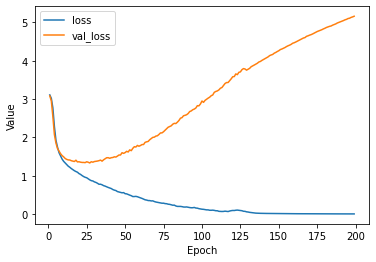

conv(128,128) dense(64,33)

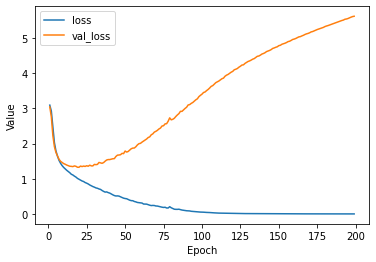

l2 regularization = 0.1 on dense(64) layer

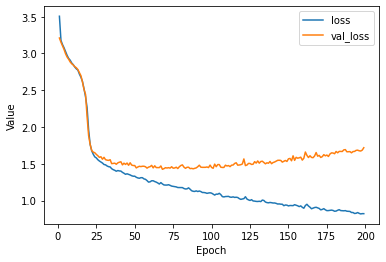

l2 reg = 0.02 on 1 conv layer and the dense layer


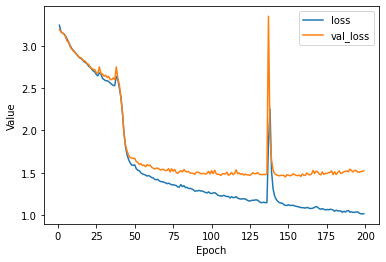